In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import trange
import math

In [2]:
general = np.load("supp_data/general.npy")
switcher = np.load("supp_data/switcher.npy")
ev_switcher = np.load("supp_data/ev_switcher.npy")

device = "cpu"

In [3]:
grn_size = 50
control = np.random.randn(grn_size, grn_size)

In [4]:
def msig(x):
    a=10
    t=-0.5
    y=1/(1+math.e**(-a*(x+t)))
    return y

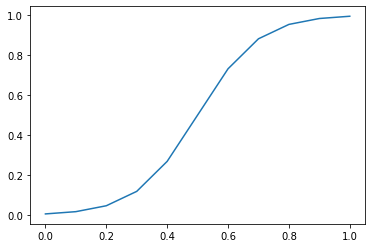

In [5]:
xs=np.arange(0,1.1,0.1)
ys=[msig(e) for e in xs]
plt.plot(xs,ys)

In [6]:
# helper functions
def fitness_function(pop, targ):
    return (1 - torch.abs(pop.squeeze(1) - targ)).sum(axis=1) / pop.size()[
        -1
    ]  # the smaller the difference, the higher the fitness


def get_phenotypes(pop, num_indv):
    state = torch.zeros(num_indv, 1, grn_size).to(device)
    state[:, :, 0] = 1.0  # create input to the GRNs

    # keeping track of the last state
    state_before = torch.zeros(num_indv, 1, grn_size).to(device)
    for l in range(max_iter):
        state = torch.matmul(state, pop)  # each matrix in the population is multiplied
        state = state * alpha
        state = torch.sigmoid(state)
        diffs = torch.abs(state_before - state).sum(axis=(1, 2))
        which_repeat = torch.where(diffs == 0)
        state_before = state

    return state

def logistic(x):
    K=10 #slope
    y = 2/(1+math.e**(-K*(x)))-1
    return(y)


ones = torch.ones(1, int(50 / 2)).to(device)
zeros = torch.zeros(1, int(50 / 2)).to(device)
targA = torch.cat((ones, zeros), 1)
targB = torch.cat((zeros, ones), 1)
targs = [targA, targB]


alpha = 10
mut_rate = 0.1
mut_size = 0.5
max_iter = 100

x = torch.tensor([0.5])
x=x.repeat(50)

# the real deal
def switcher_coeff(grn):
    num_clones = 50
    num_genes_fit = 50

    grn = torch.Tensor(grn)

    clones = grn.to(device).repeat([num_clones, 1, 1])  # create copies of parents

    # Mutate clones
    num_genes_mutate = int(grn_size * grn_size * len(clones) * mut_rate)
    mylist = torch.zeros(grn_size * grn_size * len(clones), device=device)
    mylist[:num_genes_mutate] = 1
    shuffled_idx = torch.randperm(grn_size * grn_size * len(clones), device=device)
    mask = mylist[shuffled_idx].reshape(
        len(clones), grn_size, grn_size
    )  # select genes to mutate
    clones = (
        clones
        + (clones * mask) * torch.randn(size=clones.shape, device=device) * mut_size
    )  # mutate only children only at certain genes

    # Get clone phenotypes
    clone_states = get_phenotypes(clones, num_clones)
    clone_phenos = clone_states[:, :, :num_genes_fit]

    # Get fitness
    fits = fitness_function(clone_phenos, targA)
    #one = 1 - abs(len(fits[torch.where(fits > 0.8)]) / num_clones - 0.5)
    #other = 1 - abs(len(fits[torch.where(fits < 0.2)]) / num_clones - 0.5)

    return fits.std().item() * 2
    # return (one + other) / 2
    
def specialist_coeff(grn):
    num_clones = 50
    num_genes_fit = 50

    grn = torch.Tensor(grn)

    clones = grn.to(device).repeat([num_clones, 1, 1])  # create copies of parents

    # Mutate clones
    num_genes_mutate = int(grn_size * grn_size * len(clones) * mut_rate)
    mylist = torch.zeros(grn_size * grn_size * len(clones), device=device)
    mylist[:num_genes_mutate] = 1
    shuffled_idx = torch.randperm(grn_size * grn_size * len(clones), device=device)
    mask = mylist[shuffled_idx].reshape(
        len(clones), grn_size, grn_size
    )  # select genes to mutate
    clones = (
        clones
        + (clones * mask) * torch.randn(size=clones.shape, device=device) * mut_size
    )  # mutate only children only at certain genes

    # Get clone phenotypes
    clone_states = get_phenotypes(clones, num_clones)
    clone_phenos = clone_states[:, :, :num_genes_fit]

    # Get fitness
    fits = fitness_function(clone_phenos, targA).mean().item()
    fits2 = 1-fits
    
    #one = 1 - abs(len(fits[torch.where(fits > 0.8)]) / num_clones - 0.5)
    #other = 1 - abs(len(fits[torch.where(fits < 0.2)]) / num_clones - 0.5)

    return (max(fits,fits2) - 0.5)*2
    # return (one + other) / 2


def generalist_coeff(grn):
    grn = torch.Tensor(grn)

    pheno = get_phenotypes(grn, 1)
    #fitness = (0.5 - (abs(pheno - 0.5).mean())) * 7
    dists=torch.isclose(pheno, x, atol=0.2)

    #return np.clip(fitness.item(), 0, 1)
    prop_mid=dists.sum()/50
    
    scaling=0.3
    
    #return msig(prop_mid+scaling).item()
    return prop_mid.item()


def mutate_grn(grn, mut_rate):
    grn = torch.Tensor(grn)

    num_genes_mutate = int(grn_size * grn_size * 1 * mut_rate)
    mylist = torch.zeros(grn_size * grn_size * 1, device=device)
    mylist[:num_genes_mutate] = 1
    shuffled_idx = torch.randperm(grn_size * grn_size * 1, device=device)
    mask = mylist[shuffled_idx].reshape(1, grn_size, grn_size)  # select genes to mutate
    grn = grn + (grn * mask) * torch.randn(size=grn.shape, device=device) * mut_size
    # mutate only children only at certain genes

    grn = torch.flatten(grn, start_dim=0, end_dim=1)

    return grn.detach().cpu().numpy()


def unzip(l):
    return list(zip(*l))


def trajectory(ancestor, steps=20):
    grn = np.copy(ancestor)
    coeffs = []
    for i in trange(steps):
        x, y, z = generalist_coeff(grn), specialist_coeff(grn),switcher_coeff(grn)
        grn = mutate_grn(grn, mut_rate=0.1)
        coeffs.append((x, y, z))
    return coeffs


In [48]:
REPS = 5

# TESTING SWITHER
ss=[]
for i in range(REPS):
    switcher_coeffs = trajectory(switcher)
    ss.append(switcher_coeffs)

# TESTING GENERALIST
gg=[]
for i in range(REPS):
    gene_coeffs = trajectory(general)
    gg.append(gene_coeffs)

# TESTING CONTROL
control_coeffs = trajectory(control)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.45it/s]


In [58]:
#np.save("ggs_3d",np.array(gg))
#np.save("sss_3d",np.array(ss))
#np.save("controls_3d", np.array(control_coeffs))

In [7]:
REPS = 5
gg=np.load("supp_data/ggs_3d.npy")
ss=np.load("supp_data/sss_3d.npy")
control_coeffs=np.load("supp_data/controls_3d.npy")

In [8]:
import matplotlib.animation as animation

<IPython.core.display.Javascript object>


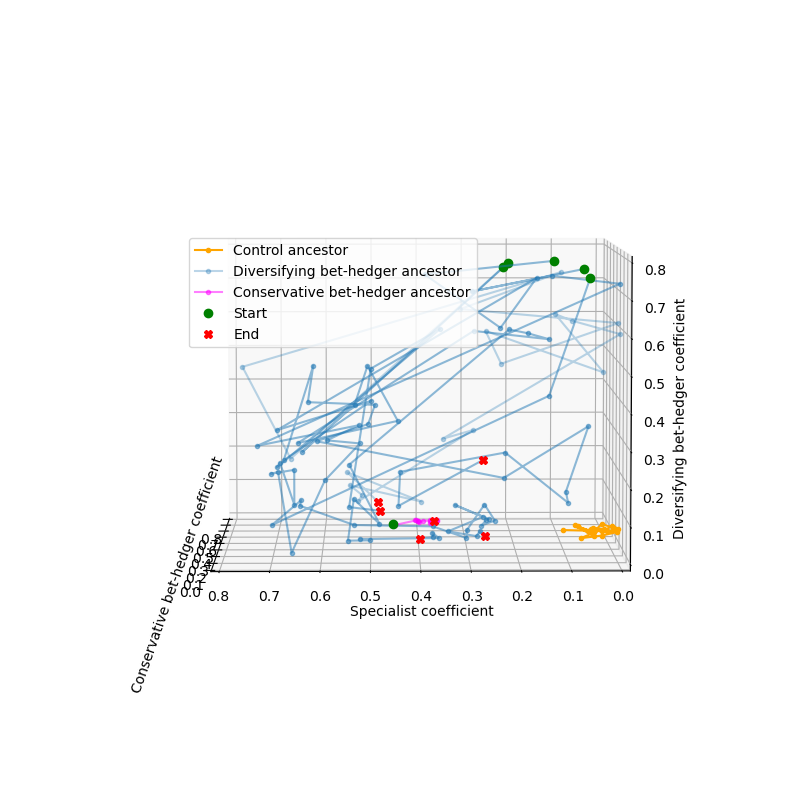

TypeError: view_init() got an unexpected keyword argument 'roll'

In [9]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111,projection='3d')

xs=np.array([s[0] for s in control_coeffs])
ys=np.array([s[1] for s in control_coeffs])
zs=np.array([s[2] for s in control_coeffs])
ax.plot(xs, ys, zs, ".-", color="orange", label="Control ancestor", alpha=1)

for i in range(REPS):
    xs=np.array([s[0] for s in ss[i]])
    ys=np.array([s[1] for s in ss[i]])
    zs=np.array([s[2] for s in ss[i]])
    if i == 0:
        ax.plot(xs, ys, zs, ".-", color="C0", label="Diversifying bet-hedger ancestor", alpha=0.3)
        ax.plot(xs[0], ys[0], zs[0], "o", color="green")
        ax.plot(xs[-1], ys[-1], zs[-1], "X", color="red")
    else:
        ax.plot(xs, ys, zs, ".-", color="C0", alpha=0.5)
        ax.plot(xs[0], ys[0], zs[0], "o", color="green")
        ax.plot(xs[-1], ys[-1], zs[-1], "X", color="red")
   

xs=np.array([s[0] for s in gg[4]])
ys=np.array([s[1] for s in gg[4]])
zs=np.array([s[2] for s in gg[4]])

ax.plot(xs, ys, zs, ".-", color="magenta", label="Conservative bet-hedger ancestor", alpha=0.5)
ax.plot(xs[0], ys[0], zs[0], "o", color="green", label="Start")
ax.plot(xs[-1], ys[-1],zs[-1], "X", color="red", label="End")

        
ax.legend(bbox_to_anchor=(0.13,0.78), loc="upper left")
#x, y, z = generalist_coeff(grn), specialist_coeff(grn),switcher_coeff(grn)
ax.set_xlabel('Conservative bet-hedger coefficient')
ax.set_ylabel('Specialist coefficient')
ax.set_zlabel('Diversifying bet-hedger coefficient')

ax.set_xlim(0, 0.8)
ax.set_ylim(0, 0.8)
ax.set_zlim(0, 0.8)
ax.view_init(elev=12., azim=70, roll=0)

#plt.savefig("mut_space_3d.pdf")

In [19]:
def animate_scatters(iteration, data, scatters):
    """
    Update the data held by the scatter plot and therefore animates it.
    Args:
        iteration (int): Current iteration of the animation
        data (list): List of the data positions at each iteration.
        scatters (list): List of all the scatters (One per element)
    Returns:
        list: List of scatters (One per element) with new coordinates
    """
    for i in range(data[0].shape[0]):
        scatters[i]._offsets3d = (data[iteration][i,0:1], data[iteration][i,1:2], data[iteration][i,2:])
    return scatters
